In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from isochrones import get_ichrone, SingleStarModel, BinaryStarModel

Holoviews not imported. Some visualizations will not be available.


In [2]:
from astroquery.mast import Observations, Catalogs

res = Catalogs.query_criteria(catalog="Tic", ID=165991532).to_pandas()

/Users/daniel/anaconda3/envs/isochrones/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/daniel/anaconda3/envs/isochrones/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'numcont' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
res

,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,165991532,20190415,68756,4174-01262-1,772-036991,14042335+6422331,NaN,J140423.31+642233.6,1667976701458550400,NaN,...,NaN,12.111298,9.383518,211.096762,64.375923,0.320942,0.278278,0,0,150439321


In [4]:
np.sin(np.radians(86.35))

0.9979715533496006

In [5]:
np.radians(86.35)

1.5070918090971035

In [6]:
def create_param_list(row):
    params = {}
    
    # Plug in magnitudes
    band_key = [
        'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 
            'J', 'H', 'K',
#         'Tycho_V'
               'WISE_W1', 'WISE_W2', 'WISE_W3', 'WISE_W4', 
               ]
    bands = [
        'gaiabp','gaiarp',
           'Jmag','Hmag','Kmag',
#         'Tycho VTmag'
            'w1mag','w2mag','w3mag','w4mag',
    ]
    avail_passbands = []
    for band, key in zip(bands, band_key):
        if not np.isnan(row[band]) and not np.isnan(row[f"e_{band}"]):
            params.update({
                 key: (row[band], row[f"e_{band}"])
#                 key: (row[band], row[f"e_Vmag_x"])
            })
            avail_passbands.append(key)
            
    # Time for some fundamental parameters. yeah baby!
    fund = ['Teff', 'logg', 'plx']
    keys = ['Teff', 'logg', 'parallax']
    
    for f, key in zip(fund, keys):
        if not np.isnan(row[f]) and not np.isnan(row[f"e_{f}"]):
            params.update({
                key: (row[f], row[f"e_{f}"])
            })
            
    return params, avail_passbands

In [19]:
def fit_isochrone(params, pb):
    mist = get_ichrone('mist', bands=pb)
    
    mod = SingleStarModel(mist, **params)
    mod.fit()
    
#     mod = BinaryStarModel(mist, **params)
#     mod.fit()
    
    return mod# Greater than 1 it favours the single model.. etc

In [20]:
params, pb = create_param_list(res.iloc[0])
params['Teff'] = (9975, 125)
params['logg'] = (3.63, 0.20)
params['parallax'] = (10.76, 0.17)

In [21]:
params

{'Gaia_BP_DR2Rev': (3.64937, 3.64937),
 'Gaia_RP_DR2Rev': (3.65669, 0.003556),
 'J': (3.434, 0.306),
 'H': (3.633, 0.224),
 'K': (3.639, 0.272),
 'WISE_W1': (3.72, 0.423),
 'WISE_W2': (3.298, 0.31),
 'WISE_W3': (3.763, 0.015),
 'WISE_W4': (3.708, 0.02),
 'Teff': (9975, 125),
 'parallax': (10.76, 0.17),
 'logg': (3.63, 0.2)}

In [22]:
mod_binary = fit_isochrone(params, pb)

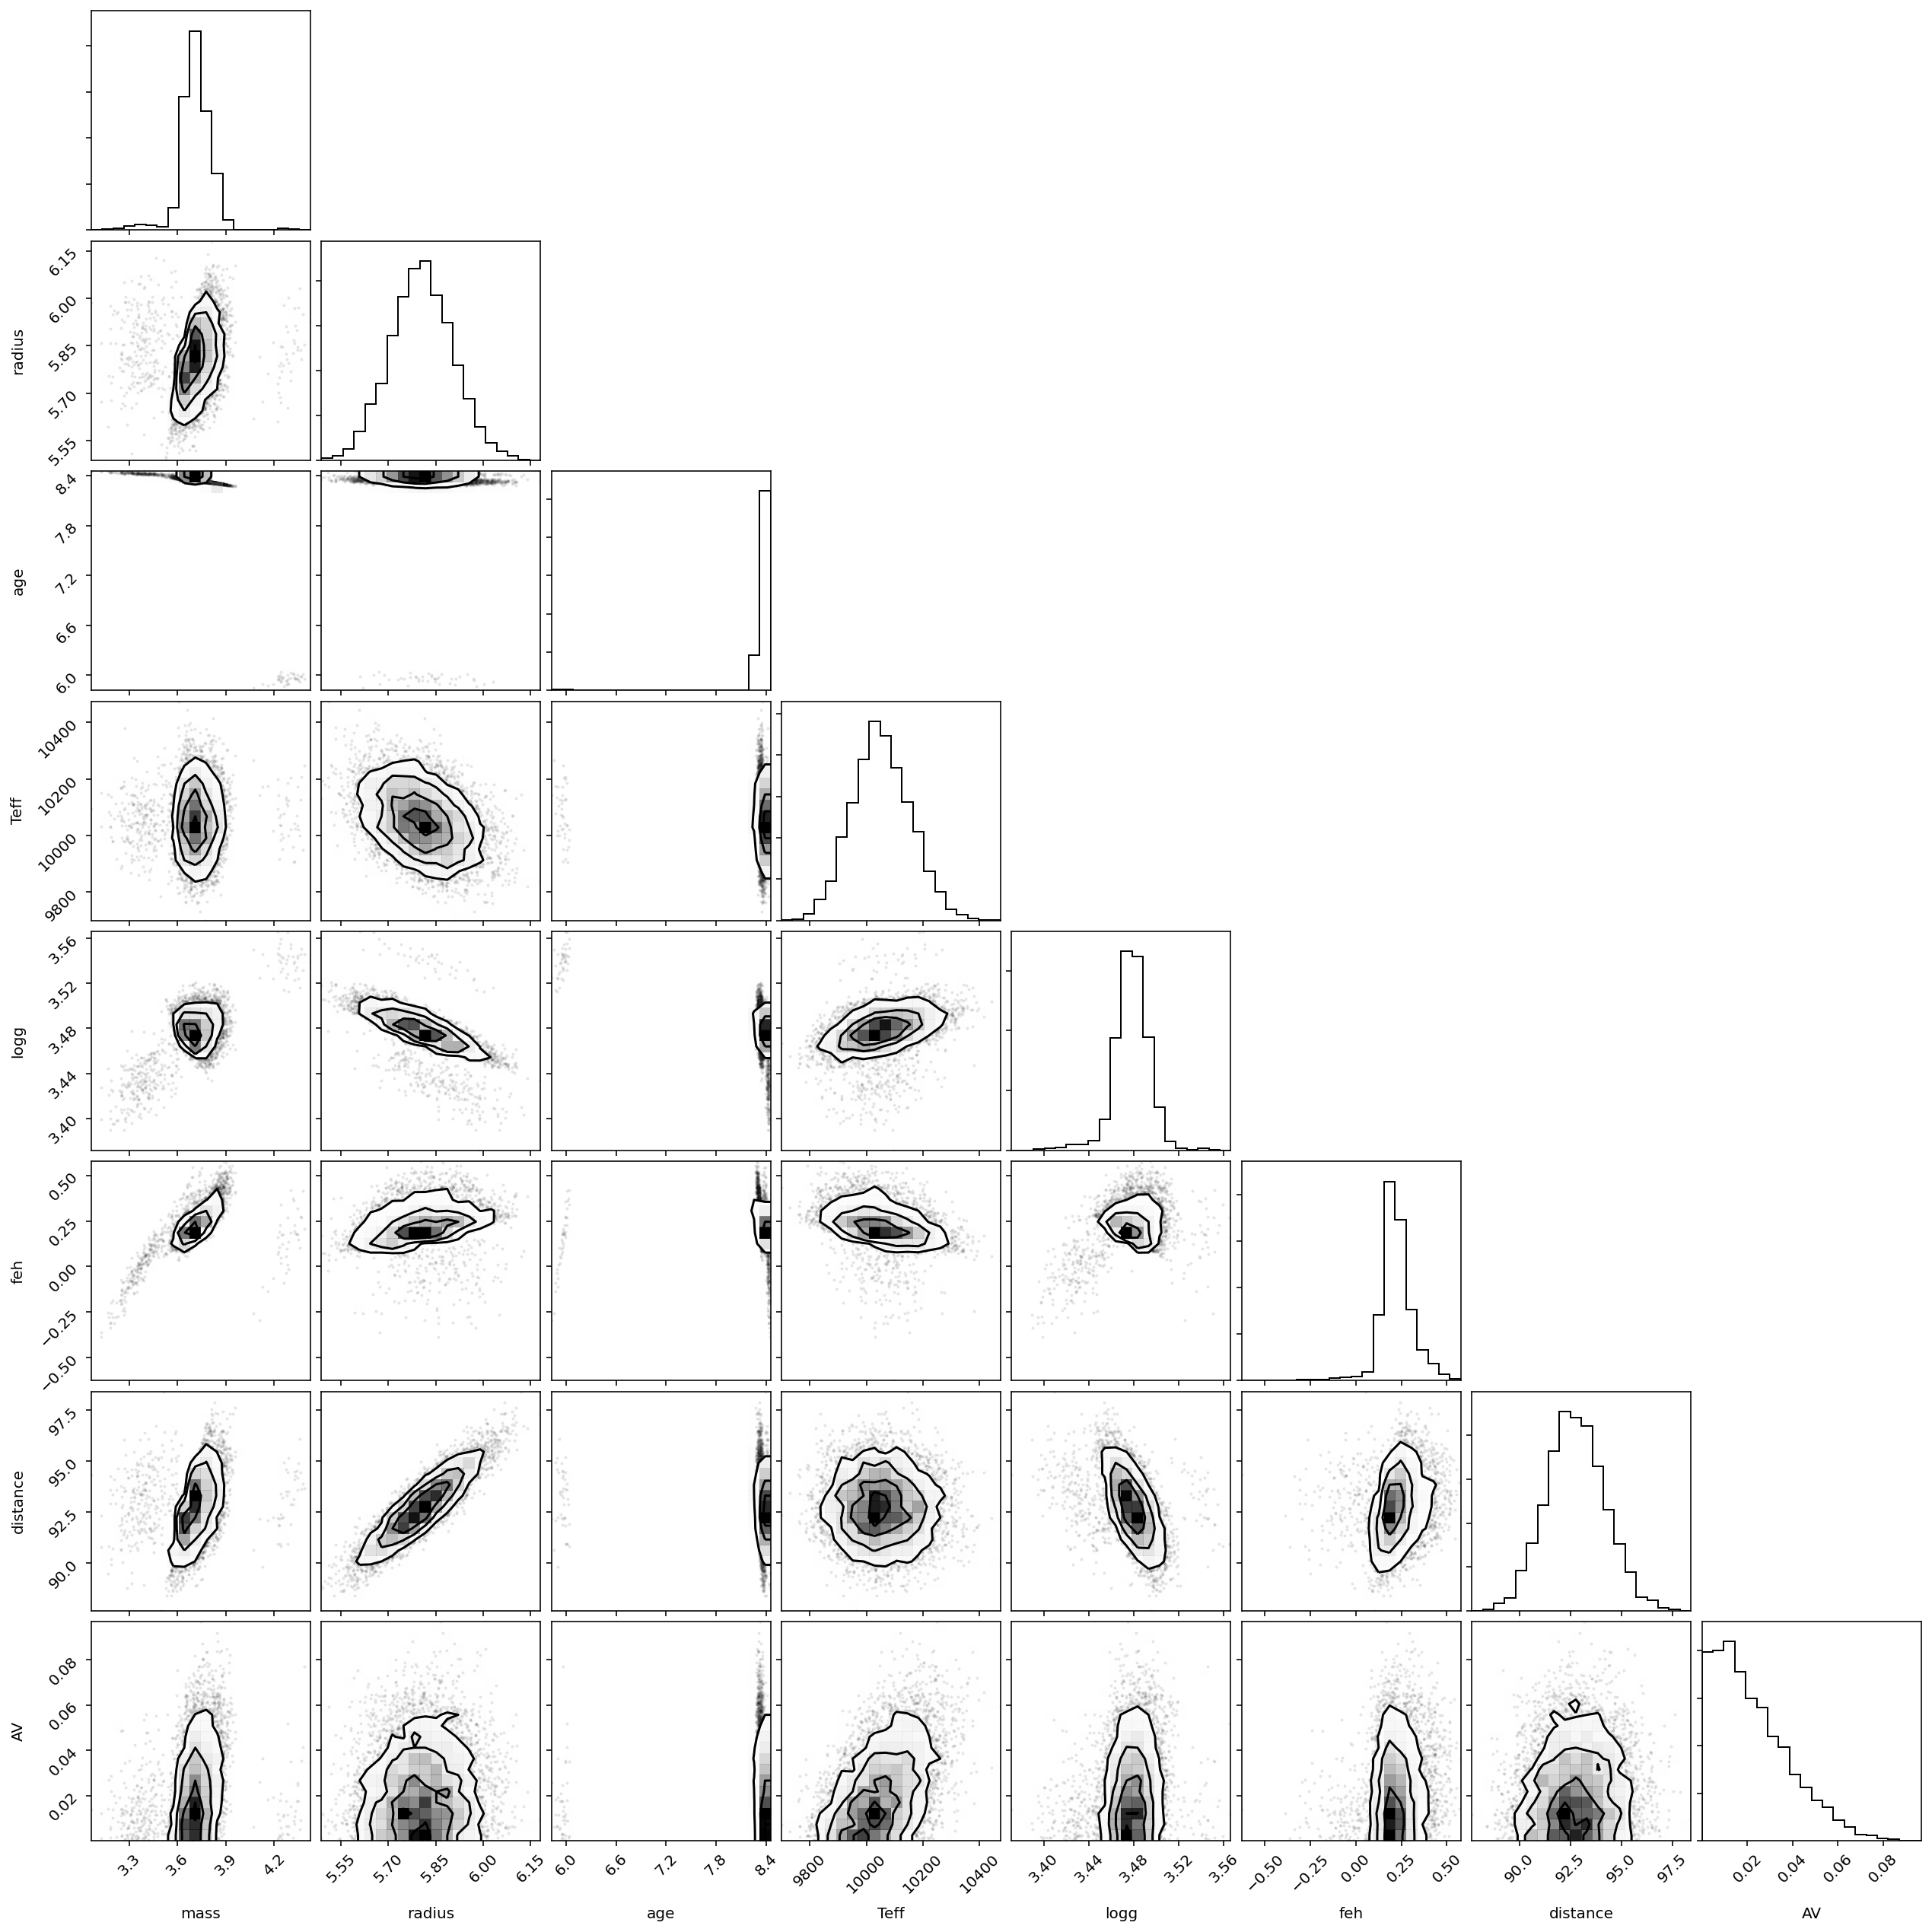

In [23]:
mod_binary.corner_physical();

In [24]:
mod = mod_binary

In [25]:
mod.derived_samples.columns

Index(['eep', 'age', 'feh', 'mass', 'initial_mass', 'radius', 'density',
       'logTeff', 'Teff', 'logg', 'logL', 'Mbol', 'delta_nu', 'nu_max',
       'phase', 'dm_deep', 'Gaia_BP_DR2Rev_mag', 'Gaia_RP_DR2Rev_mag', 'J_mag',
       'H_mag', 'K_mag', 'WISE_W1_mag', 'WISE_W2_mag', 'WISE_W3_mag',
       'WISE_W4_mag', 'parallax', 'distance', 'AV'],
      dtype='object')

In [26]:
10**np.median(mod.derived_samples.logL)

308.97956275513513

In [27]:
mod.derived_samples.Mbol

0      -1.642608
1      -1.553594
2      -1.463135
3      -1.529601
4      -1.416519
          ...   
6154   -1.484082
6155   -1.481580
6156   -1.477096
6157   -1.447985
6158   -1.473428
Name: Mbol, Length: 6159, dtype: float64

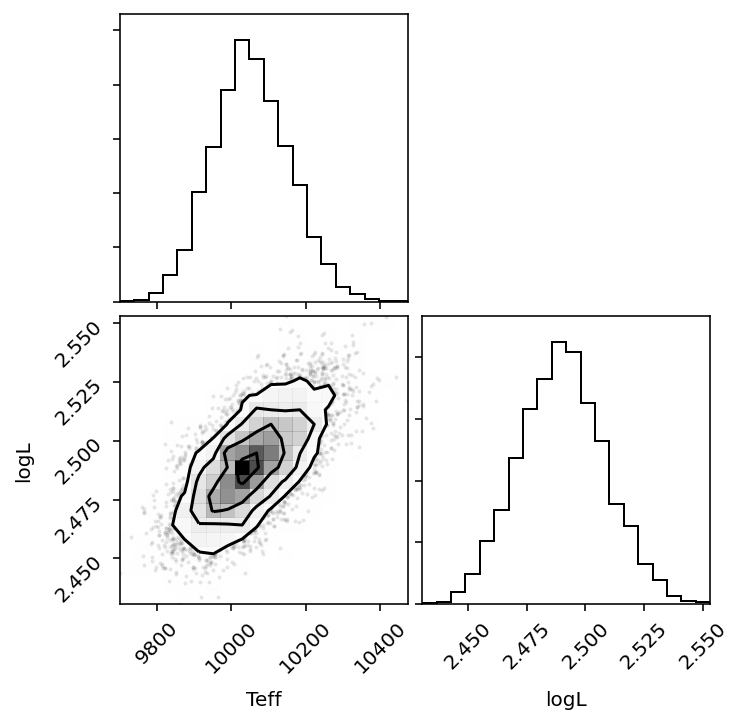

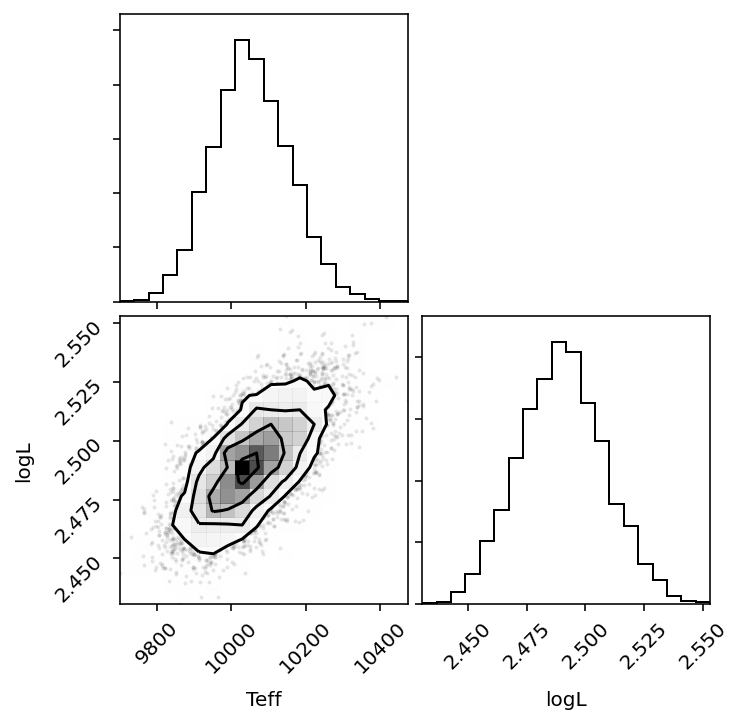

In [28]:
mod.corner_derived(cols=['Teff', 'logL'])

In [29]:
mod.derived_samples

,eep,age,feh,mass,initial_mass,radius,density,logTeff,Teff,logg,...,J_mag,H_mag,K_mag,WISE_W1_mag,WISE_W2_mag,WISE_W3_mag,WISE_W4_mag,parallax,distance,AV
0,453.949392,8.390709,0.053935,3.512476,3.514814,6.120862,0.021635,4.006249,10146.466262,3.409953,...,3.690981,3.704295,3.717375,3.725061,3.729828,3.737041,3.746972,10.162728,98.398777,0.009302
1,397.846736,8.353846,0.036220,3.607103,3.609436,5.511937,0.030428,4.020089,10474.490167,3.512753,...,3.690464,3.703335,3.716161,3.724077,3.729107,3.736982,3.747493,11.120808,89.921521,0.059122
2,443.259497,8.412836,0.307462,3.592363,3.594772,5.831633,0.025548,3.998776,9972.956305,3.458139,...,3.679491,3.686415,3.694473,3.698581,3.702124,3.708917,3.720021,10.875128,91.952944,0.064240
3,398.228095,8.350349,0.217976,3.723544,3.725957,5.916093,0.025633,4.002527,10063.223009,3.463376,...,3.686257,3.693166,3.701489,3.705604,3.709087,3.715504,3.726094,10.669080,93.728796,0.070777
4,446.600317,8.434431,0.256704,3.494482,3.496828,5.936192,0.023728,3.990415,9785.202929,3.432176,...,3.677654,3.684635,3.692390,3.696154,3.699379,3.705266,3.715564,10.801337,92.581133,0.029331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6154,395.506334,8.354076,0.142213,3.654193,3.656507,5.721377,0.027745,4.005207,10125.530739,3.485174,...,3.697569,3.712614,3.725790,3.734261,3.739485,3.747470,3.758103,10.838366,92.264827,0.000703
6155,394.829693,8.350741,0.144499,3.660559,3.662854,5.703552,0.028036,4.005616,10134.569261,3.488568,...,3.695879,3.710386,3.723232,3.731429,3.736550,3.744449,3.755090,10.880690,91.905940,0.007127
6156,396.915944,8.362816,0.146361,3.637704,3.640045,5.733473,0.027500,4.004099,10100.781956,3.481443,...,3.694501,3.708040,3.720266,3.727880,3.732742,3.740315,3.750821,10.869323,92.002054,0.011482
6157,397.725230,8.369459,0.213071,3.658266,3.660634,5.852244,0.026022,3.996743,9931.315715,3.465129,...,3.690533,3.702910,3.714034,3.720795,3.725294,3.732511,3.743071,10.765540,92.888973,0.001701


In [30]:
from IPython.display import display, Math

for i in ['mass', 'logL', 'radius', 'Teff']:
    mcmc = np.percentile(mod.derived_samples[i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
#     display(Math(txt))
    print(txt)

\mathrm{mass} = 3.710_{-0.068}^{+0.088}
\mathrm{logL} = 2.490_{-0.018}^{+0.018}
\mathrm{radius} = 5.805_{-0.095}^{+0.099}
\mathrm{Teff} = 10049.867_{-98.658}^{+108.065}


# Estimating the sec

In [59]:
M2 = 2.49978
M2 * np.sqrt( (3 * (0.04 / 86.35))**2 + (2 * (0.1 / 3.5))**2)

0.1428868074935514

In [60]:
40 / 240

0.16666666666666666

In [18]:
import numpy as np
import astropy.units as u
import astropy.constants as c


In [25]:
((1 * u.M_sun).to(u.g) / ((1 * u.R_sun).to(u.cm)**2)) * c.G.to(u.cm**3 / (u.g * u.s**2))

<Quantity 27420.01116574 cm / s2>

In [26]:
np.log10(27420)

4.438067450453494

In [27]:
1 / 3.5

0.2857142857142857

In [37]:
np.log10(40)

1.6020599913279623

In [38]:
mod_binary.derived_samples.columns

Index(['eep_0', 'eep_1', 'age', 'feh', 'distance', 'AV', 'lnprob', 'feh_0',
       'mass_0', 'initial_mass_0', 'radius_0', 'density_0', 'logTeff_0',
       'Teff_0', 'logg_0', 'logL_0', 'Mbol_0', 'delta_nu_0', 'nu_max_0',
       'phase_0', 'dm_deep_0', 'V_mag_0', 'J_mag_0', 'H_mag_0', 'K_mag_0',
       'feh_1', 'mass_1', 'initial_mass_1', 'radius_1', 'density_1',
       'logTeff_1', 'Teff_1', 'logg_1', 'logL_1', 'Mbol_1', 'delta_nu_1',
       'nu_max_1', 'phase_1', 'dm_deep_1', 'V_mag_1', 'J_mag_1', 'H_mag_1',
       'K_mag_1', 'V_mag', 'J_mag', 'H_mag', 'K_mag', 'parallax'],
      dtype='object')

In [39]:
np.median(mod_binary.derived_samples.logL_1)

-2.093377483405772

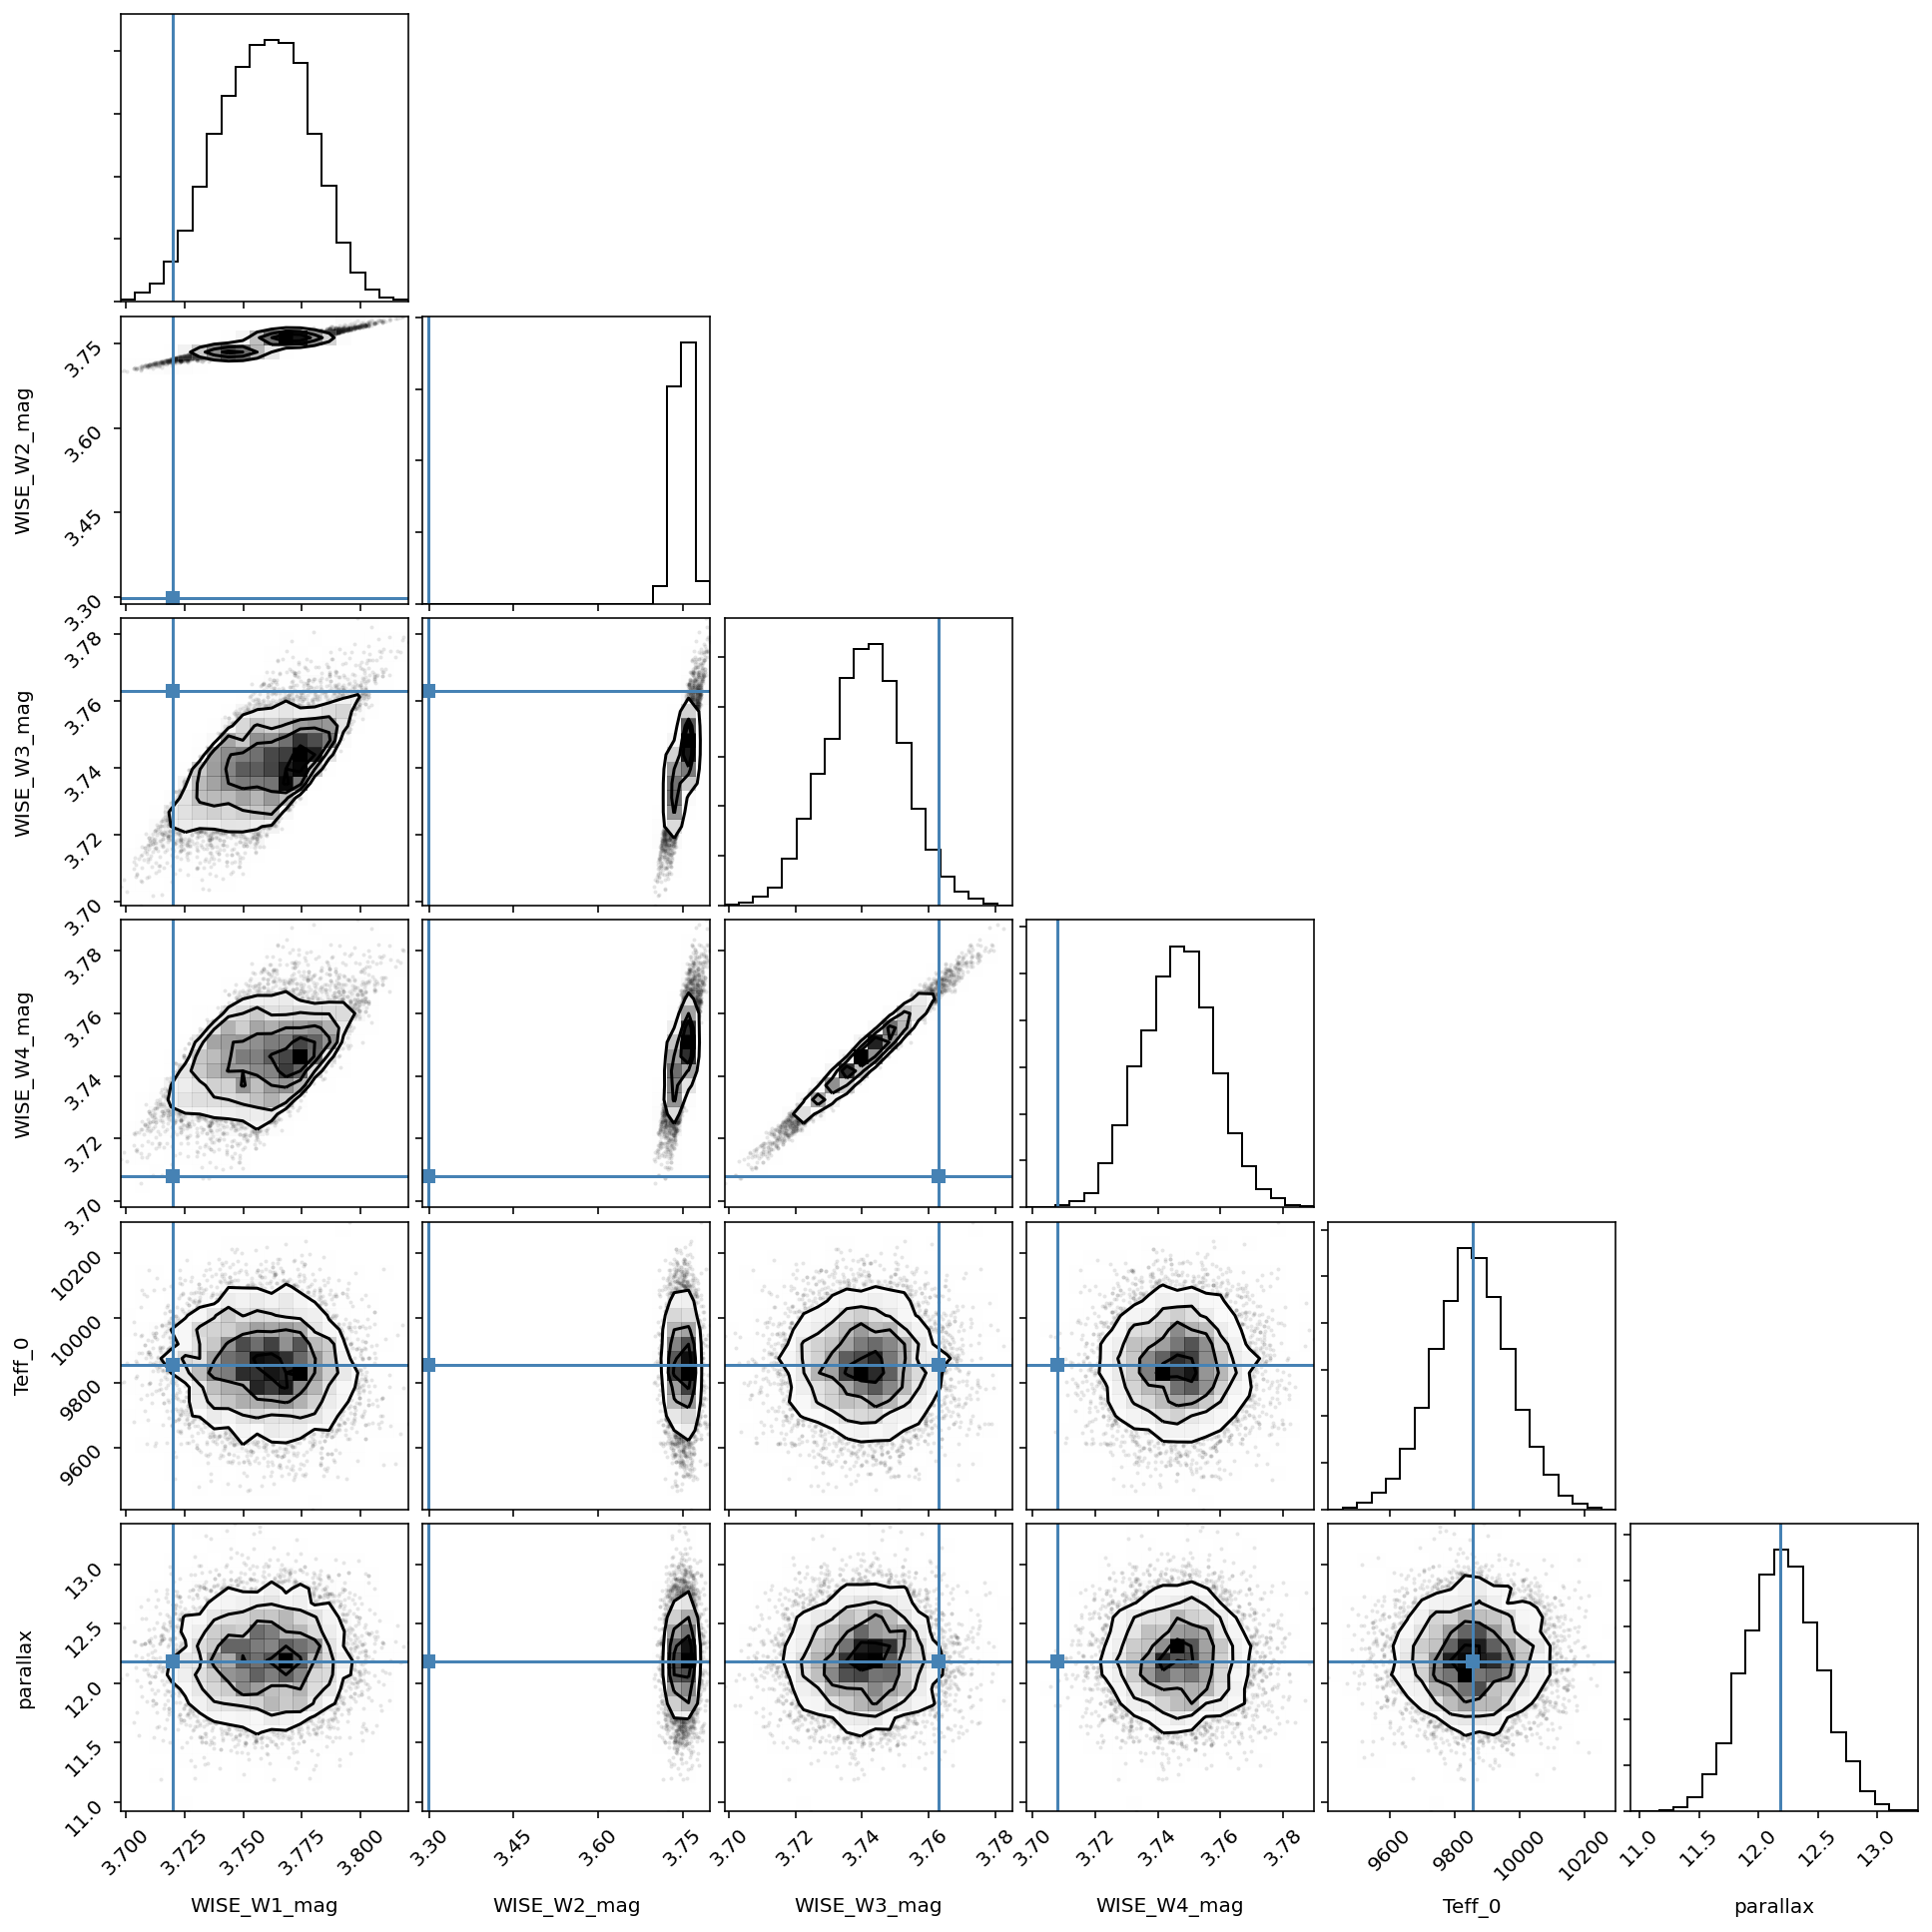

In [46]:
mod_binary.corner_observed();